# NIH Chest X-ray classification using mobilenet

### Goal

The goal is to use a simple model to classify x-ray images in Keras

##Data Aggregation

In [0]:
image_path = "dbfs:/FileStore/tables/images" 

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [0]:
# reading the data
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType

df = (sqlContext.read.format("csv").
  option("header", "true").
  option("nullValue", "NA").
  option("inferSchema", True).
  option("encoding", "UTF-8").
  option("ignoreLeadingWhiteSpace", True).
  option("ignoreTrailingWhiteSpace", True).
  option("multiLine", True).
  load("/FileStore/tables/Data_Entry_2017.csv")) #file path in dbfs file system

df.printSchema()


root
-- Image Index: string (nullable = true)
-- Finding Labels: string (nullable = true)
-- Follow-up #: integer (nullable = true)
-- Patient ID: integer (nullable = true)
-- Patient Age: integer (nullable = true)
-- Patient Gender: string (nullable = true)
-- View Position: string (nullable = true)
-- OriginalImage[Width: integer (nullable = true)
-- Height]: integer (nullable = true)
-- OriginalImagePixelSpacing[x: double (nullable = true)
-- y]: double (nullable = true)
-- _c11: string (nullable = true)

check if images are loaded properly

In [0]:
imageDf = spark.read.format("image").load(image_path) #we can set images to df using spark.read method
display(imageDf.limit(5)) #limit() is to limiting the number of images shown  

image List(dbfs:/FileStore/tables/images/00029745_001.png, 1024, 1024, 4, 24, Binary image data placeholder. Access the image data field directly to view raw binary data., iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAYAAABw4pVUAAArr0lEQVR42rXd5bLsyLWu4boAhx22O9rR5ja0mZmZmZmZmZmZmZmZmZmZ2va1aJ83O54Zo3Xmsv/svSJyqUolKTPHNzhHah7Odrazbec85zmP2jnOcY7Vzn72sx+1vp900knbySefvJ3rXOfaTjnllO3c5z73dp7znGc7//nPv5166qnbRS5yke1Sl7rUdvnLX34dL3nJS26nnXbaOn/Na15zu+ENb7jd4AY3WO1GN7rRduMb33i76U1vut385jffbnGLW2y3u93tVrvtbW+73fGOd9zudKc7bfe4xz22hz3sYdsjH/nI7b73ve/67a53vetqfX/wgx+83f/+99/ucpe7rN9udatbrWfd5CY3Oervute97nad61xnu9a1rrVd/epX36561atuV7nKVbYrXvGKa6yXucxltotd7GLbxS9+8TO1zl30ohdd47/whS+82oUudKEzNfNurj2/PptrfVztaldbxytc4QrbBS5wgSM6dYx+tT6f5Sxn2c561rNul770pdczD4EQoRG7YwOPIBEs4t3nPvfZbn3rW2/3vve9t9vf/vZrov1+/etffxExAvRAEwyQWpOqNTjP2gNys5vdbLvlLW+53eEOd9judre7bbe5zW0WIH2O6A996EMXKIFTnw95yEO2e93rXmssD3jAA1br2gAJjFrPa7z6C5BrX/va2zWucY1FpNqVr3zlBUoEw0Adm4fx1y5xiUssgDBXwDTPxt+YY46O9V8LkPqJhs078HuOfvveNdGsuQZWGDTmBUgA4HatCyN8HNfEnvOc5yxOq8OnPvWp21Oe8pTtEY94xOLMBz3oQevhAdFkOl72spddxybTuQbXNROQvjepJGQC0jFA7n73u2/3vOc9lwQkCZ1rXAHR+QCKUdzTWAO38QZKY60PgDT+uDgi4d6IQ1oa7+Uud7kFUMfmYB6B1VwidEwRQzQe0tgcatEs4D2/+TWPWuOMAc0/Rm4e3R/TNs9AP5zvfOdbyFzwghdcaHWMAzp3vetdb00mbqqTCNvnJh8RGlyDiKAmZFI9owl1bCJJU4PpmX1uULWISCrufOc7r+fFdRG8SXQMhPro+o5dX/9d756+N8l+b+IdI1hEiUiB0RHnOuLm5nWlK13pCCDS0/j7rWdHtIjYWBtjwPS9MfR75+q370lujJREN7aYt3FrAdj9jTUax9gdD+nJ0A/RiElEqZu+J3I4v0ac+9w9DbpmIk3KBGtNOGKkY+PUgAFKg4urm1AD73MEblJNsAk38AjbgLuvzzFFk6xhjJ4VQQI5MJp0E44L67/7a40ngPqM6ag1tqZxN5cAq4+kkVRGvAc+8IFrbPVbP40nBgqErgdYajcAzS3JzSZ2b+Ou38Yc2N1/SJ91skk2oS5KxOq4i3pgF9Zhg49r6NtACojONfgmERCMGpXQpBi9nkFSmghAGmh9d2zwuL5xUFld3zWB1ffG16S7rudwCpogNcKmBAoppcKoD6oUozS2xt81mCIaBMSjH/3o1WegByA72nWNKXr1uXFqAdRv0fAb3/jGdvrpp28f/ehHl9pv3M0xW3m/+91vO3SiCTepHt4gOtZhD4kr6iQRTPwY1X6nbzsGRMQHRiBQB7iT59OE41xErAUKQnfEZamrBto1Bl9rov1Wi1h9x4VNPBBq7GDANObGUGuOgdQ5tqbzgdP4up66jEEDP87umebSc+u7sZLork162A3PmPbxSU960vbTn/50e9aznrWe+4xnPGOd6/MhLorgeTKdaOJ0ezfHHQal066PW/qtwSUlgQGIpC5gmxi3s89NghFkN2qITbRJS/3Wj3GRCmqg/gOr1vXAoLpIR+dIC8MKEJ5ev3fsewTumTFeLQLHiP1GsusvImsRnnqN22PyntH40ap5dYy5v//972/Pfvaz17UveMELFiCPetSjtkOd0He1HtIAuHNigh7U+R4eh3ZtD444qbvACIikoUF3LmCpqY7UInW01/19Bk6fmygAABVIXGDSErN0nzik1v1UITtDGqkvjNd9tX7r+fXX/Hp2c+wYCF3P6ahPzBlRUz+Pecxjtsc+9rELjFRbTB7dGkdtapqkLY81EF70ohdtz3zmM9f3Q4OnJriP3dy5BtXvcX0E7bcG3MMaxBx09wZGEtGEZ5sxB/HmutK39dezjaNjv8cgPb/rprGv1Xf39LnnUn0kDyHo+FogR8zm0rgaE86NYNQgVdmxZ9AY3Fiq6OEPf/hqgfG0pz1tcXuqqNAgUBpv84uxXBsIARcAT3/607cXv/jFC5TuXTaEt0J3OzJmEUj0G7c3OKA06AhjMg1ebEGX49qe2XVJWseej6gCvQZuwlRj14vGPVc8oF9GtbFTIzgZCF1bf/W794RIW8/i0HTkKHhW49IaWzQASGqnmI1NeNzjHrfO10cgBFDfOx8YScVLX/rS7RWveMX26le/enve8563HRpsE+4mHSJUDTg+J+rZhAjcfdIXxLxjIHUPtRHoPZs6TLypgvpiCxJlACCKCfP/RcT11fVd25gFksBwLWOeNDQWjoJxNw52CjDsEsmbgSh1zcVNLeH4Jz7xiYuocX1zDICI329PfvKTtyc84Qnrmj4/97nPXe01r3nN9pKXvGR75Stfub4fGmgdNyjcVkcRou9NtInjXDo4fZrkdD6idDQR0bW0Bm7vXK3vUin1X4vze3bXN+Ge4TlNTlA2QY8Y9U3v12IarnTPlzLJ28uYNwcS2fWYALiAIUHmpwkD+r17AiOuj9hxfIBE8DRIxNdITmqNZAREkpG6Skqe//znbwceTZ33kB6eOPWAEI4gdRoBqIGuF3g1MJw2B0+cIxp3mWqJ+IJEdkcAV5NYRLDG0bPpbf0EVNLDo+nZUiiBnHoNjPro+WwAJqn1rMZY61mNmZtKohsDzwmAjS16RfzUU8R+4QtfuFrgUEt+67poGtG7JonIdgTIy172svU9gA4G2WAe//jHLzRDLLHrQbU66PcGYSJNPo7mDRk4N68JRrBakzGJrg3IuDWvLM6NaDPPJVpvXN1X39xQkbLz9dPz618AK7YIhBiHLZtqzWfPi7iNtefFALXO1Ue/cy6aY9dF8Lg94iYVEbvPEXUPREY+qYim0fZVr3rVAiJ19brXvW4dX/va1y5gDgKZHhAHRPxQ7ME9qM57KC7pSLVFIJ6LmMGAuYFNkH3huUSICCVtIRDD2dMt7nrOA+nQD+nrdyoWsyT5Mx7p2dPg1wBCzQKDAQ4QoJByBjzGzZOiTYop2IXOTyD6PdD67eUvf/kC4O1vf/v2xje+cQHyhje8YXvLW96yve9979sOTZKxqbMMELGq9bAGGFgNPvAQoHM4XxxDr8ZBgk3GcO8sMMapvT5zTxuTdINAi1c2AcEgbF4cbBy8LklH2VUGGoPUv2RhwDDGzYE6JOE+d405xshJSsSObgGTJNRIDiCyG6mpmD0pCYy3vvWtC5A3velN63ioox4aokS1h3QjO4JLqAzqiAfRd5yMyzoKIps428JNntnaWoSRFe0+9mYCwuDT5Xz6vjdGtkuiTkDYc6X3xRGkjUeGQXpGz+x5zcOcHJu335p/zBz9AqA4IkACKHXV90CKlrVUUqB0pK6SlA996EPbxz72se3d7373dqiDHproJYoNJpELjI7ZlTpMgpoAQgREA+II9AxcE4G4hnQvw8/dlTaXc/I9YgGAN8RG8Pp6dsTBEAx/4+IpiealZEhnvzHa9ScFIgNQo5Z6NrVLMoAhngBIIEQz3hSPKyBIBuOdR5VkBEbHgEh9vfOd

##Data Transformation

In [0]:
#Add a new column path which directs to the path of image
pathSetter = udf(lambda row: '/dbfs/FileStore/tables/images/'+row, StringType())
df = df.withColumn('path', pathSetter('Image Index'))


In [0]:
data = df.toPandas()
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x))
data.sample(3)

Scans found: 0 , Total Headers 112104
Out[13]:

Image Index 
 Finding Labels 
 Follow-up # 
 Patient ID 
 Patient Age 
 Patient Gender 
 View Position 
 OriginalImage[Width 
 Height] 
 OriginalImagePixelSpacing[x 
 y] 
 _c11 
 path 
 
 
 
 
 79461 
 00019522_003.png 
 Infiltration 
 3 
 19522 
 69 
 F 
 AP 
 2500 
 2048 
 0.168 
 0.168 
 None 
 /dbfs/FileStore/tables/images/00019522_003.png 
 
 
 39771 
 00010384_025.png 
 No Finding 
 25 
 10384 
 17 
 F 
 AP 
 2048 
 2500 
 0.168 
 0.168 
 None 
 /dbfs/FileStore/tables/images/00010384_025.png 
 
 
 19767 
 00005262_001.png 
 No Finding 
 1 
 5262 
 21 
 M 
 PA 
 2048 
 2500 
 0.171 
 0.171 
 None 
 /dbfs/FileStore/tables/images/00005262_001.png

In [0]:
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Out[11]:

Image Index 
 Finding Labels 
 Follow-up # 
 Patient ID 
 Patient Age 
 Patient Gender 
 View Position 
 OriginalImage[Width 
 Height] 
 OriginalImagePixelSpacing[x 
 y] 
 _c11 
 path 
 Atelectasis 
 Cardiomegaly 
 Consolidation 
 Edema 
 Effusion 
 Emphysema 
 Fibrosis 
 Hernia 
 Infiltration 
 Mass 
 Nodule 
 Pleural_Thickening 
 Pneumonia 
 Pneumothorax 
 
 
 
 
 78525 
 00019271_008.png 
 
 8 
 19271 
 54 
 M 
 AP 
 3056 
 2544 
 0.139 
 0.139 
 None 
 None 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 72356 
 00017830_007.png 
 Effusion|Pneumothorax 
 7 
 17830 
 53 
 M 
 PA 
 2992 
 2991 
 0.143 
 0.143 
 None 
 None 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 
 
 102960 
 00027442_005.png 
 
 5 
 27442 
 11 
 F 
 AP 
 3056 
 2544 
 0.139 
 0.139 
 None 
 None 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0

In [0]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])


Clean Labels (13) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]

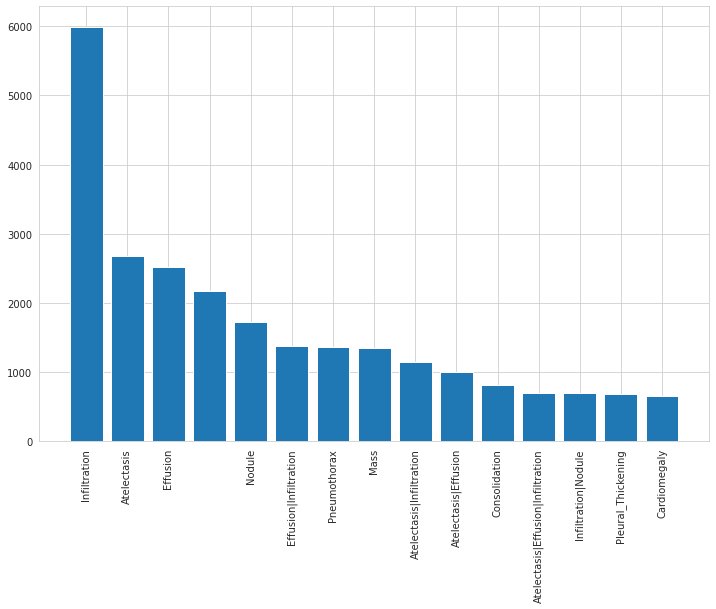

In [0]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.04 + number of findings
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(40000, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)


In [0]:
# creating vector of diseases
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])


##Modeling
Splitting the dataset to train set validation set and test set

In [0]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 32000 test 8000


In [0]:
train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = train_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'valid', valid_df.shape[0])

train 28800 valid 3200


converting the image size, sample centring, normalization on image.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)


Using TensorFlow backend.


In [0]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0]) 
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen


The csv file is given as input to flow_from_data to generate train_gen and valid_gen.

In [0]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 16)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 16) 
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) 

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 28800 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3200 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3200 images


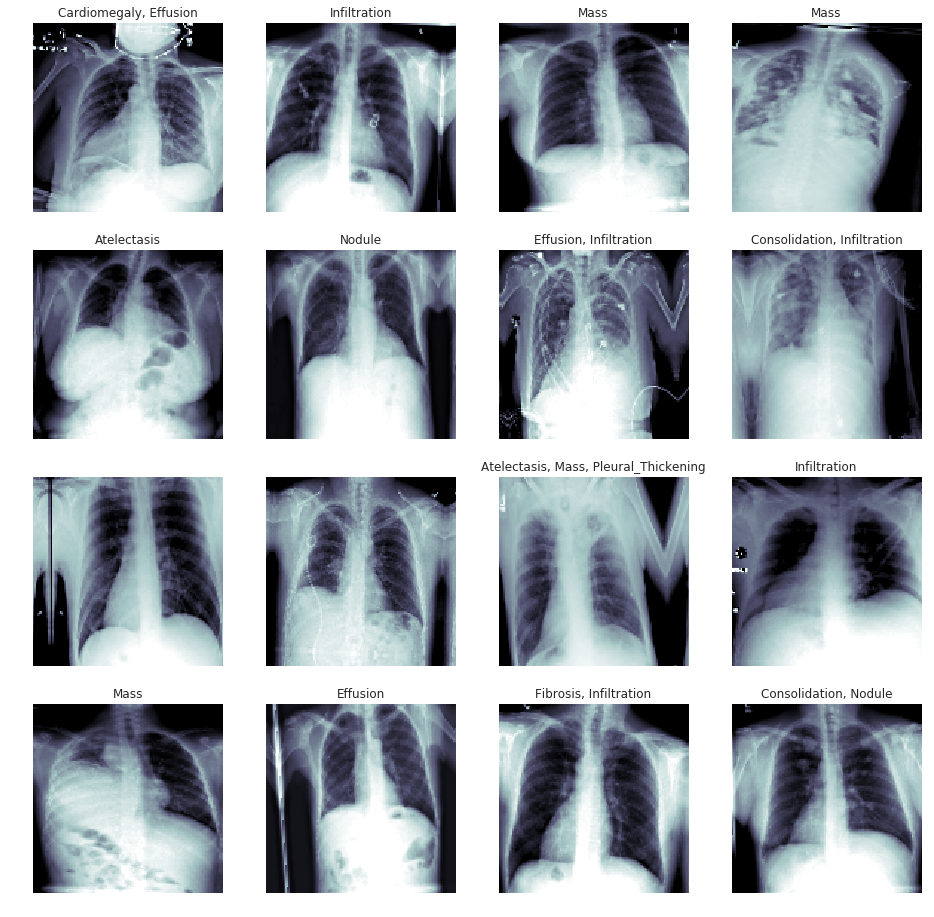

In [0]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()): #for loop for ploting image.
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [0]:
###MobileNet model

initialize the model

In [0]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                6669      
Total params: 3,759,757
Trainable params: 3,737,869
Non-trainable params: 21,888
_____________________________________________________________

###Training Model

In [0]:
history = multi_disease_model.fit_generator(train_gen,   #train dataset
                                  steps_per_epoch=100, 
                                  validation_data = valid_gen,  #validation dataset
                                  epochs = 30) #number of episodes
                                  

Epoch 1/30
100/100 [==============================] - 96s 956ms/step - loss: 0.4654 - binary_accuracy: 0.8420 - mean_absolute_error: 0.1976 - val_loss: 0.8961 - val_binary_accuracy: 0.8580 - val_mean_absolute_error: 0.1468
Epoch 2/30
100/100 [==============================] - 80s 800ms/step - loss: 0.4160 - binary_accuracy: 0.8512 - mean_absolute_error: 0.1933 - val_loss: 1.0191 - val_binary_accuracy: 0.7783 - val_mean_absolute_error: 0.2180
Epoch 3/30
100/100 [==============================] - 79s 792ms/step - loss: 0.4005 - binary_accuracy: 0.8555 - mean_absolute_error: 0.1988 - val_loss: 0.6543 - val_binary_accuracy: 0.8770 - val_mean_absolute_error: 0.1376
Epoch 4/30
100/100 [==============================] - 79s 791ms/step - loss: 0.3695 - binary_accuracy: 0.8608 - mean_absolute_error: 0.1967 - val_loss: 0.3769 - val_binary_accuracy: 0.8714 - val_mean_absolute_error: 0.1566
Epoch 5/30
100/100 [==============================] - 80s 800ms/step - loss: 0.3582 - binary_accuracy: 0.867

###Model Evaluvation

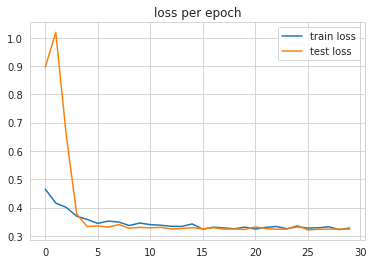

In [0]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.title('loss per epoch')
plt.show()

In [0]:
print('test binary accuracy = ',multi_disease_model.evaluate(test_X,test_Y, verbose=0)[1])

test binary accuracy =  0.8819862008094788


In [0]:
y_pred = multi_disease_model.predict(test_X)

In [0]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(y_pred,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: actual: 22.27%, predicted: 21.06%
Cardiomegaly: actual: 4.39%, predicted: 6.02%
Consolidation: actual: 9.28%, predicted: 7.33%
Edema: actual: 4.00%, predicted: 4.68%
Effusion: actual: 26.66%, predicted: 20.71%
Emphysema: actual: 5.08%, predicted: 4.16%
Fibrosis: actual: 2.83%, predicted: 3.70%
Infiltration: actual: 36.82%, predicted: 40.02%
Mass: actual: 11.13%, predicted: 10.04%
Nodule: actual: 12.50%, predicted: 17.22%
Pleural_Thickening: actual: 6.93%, predicted: 5.77%
Pneumonia: actual: 3.03%, predicted: 3.28%
Pneumothorax: actual: 10.45%, predicted: 7.64%


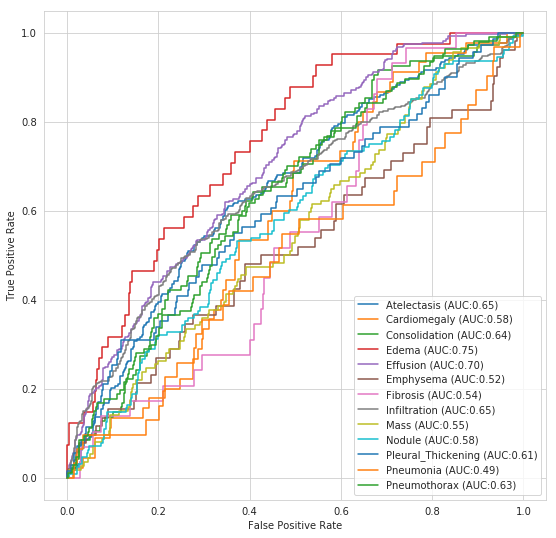

In [0]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')


In [0]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(test_Y.astype(int), y_pred))

roc score =  0.6067806643240767
